In [211]:
import requests
from pprint import pprint
from PIL import Image
import os
import shutil
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [212]:
def load_from_pickle(pathIn):
    ar_file = open(pathIn, "rb")
    res = pickle.load(ar_file)
    ar_file.close()
    return res

In [213]:
def dump_to_pickle(obj, target_path):
    target_file = open(target_path, 'wb')
    pickle.dump(obj, target_file)
    target_file.close()

In [214]:
def flood_fill(img, blobs_map, flood_ix, a, b, expected_color):
        pixels_queue = []
        pixels_queue.append((a, b))

        while (len(pixels_queue) > 0):
            pos = pixels_queue.pop(0)
            a, b = pos
            
            if img[a, b] == expected_color and blobs_map[a, b] < 0: # expected color and still not set
                blobs_map[a, b] = flood_ix

                new_a = a - 1
                new_b = b
                
                if new_a >= 0:
                    pixels_queue.append((new_a, new_b))

                new_a = a
                new_b = b - 1
                
                if new_b >= 0:
                    pixels_queue.append((new_a, new_b))
                    
                new_a = a
                new_b = b + 1
                
                if new_b < blobs_map.shape[1]:
                    pixels_queue.append((new_a, new_b))

                new_a = a + 1
                new_b = b
                
                if new_a < blobs_map.shape[0]:
                    pixels_queue.append((new_a, new_b))
                    

In [259]:
def transform_blob_details(blobs):
    blobs_list = []
    
    for blob in blobs.values():
        blob_ix, min_a, min_b, max_a, max_b, pixel_count = blob
        width = max_b - min_b + 1
        height = max_a - min_a + 1
        rectangle_size = width * height
        blob = (blob_ix, (min_a, min_b), (max_a, max_b), (width, height), rectangle_size, pixel_count, pixel_count * 1.0 / rectangle_size)
        blobs_list.append(blob)
        
    return blobs_list

In [265]:
def enhance_blobs(blobs, avg_disk_area):
    blobs_list = []
    
    for blob in blobs:
        (blob_ix, (min_a, min_b), (max_a, max_b), (width, height), rectangle_size, pixel_count, pixel_count_ratio) = blob
        
        ell_a = width / 2.0
        ell_b = height / 2.0
        approx_ell_area = math.pi * ell_a * ell_b
        
        area_to_ell_ratio = pixel_count * 1.0 / approx_ell_area
        if area_to_ell_ratio > 1.0:
            area_to_ell_ratio = 1.0 / area_to_ell_ratio

        are_to_avg_ratio = pixel_count * 1.0 / avg_disk_area
        if are_to_avg_ratio > 1.0:
            are_to_avg_ratio = 1.0 / are_to_avg_ratio
            
        ratio_mul = area_to_ell_ratio * are_to_avg_ratio
            
        blob = (blob_ix, (min_a, min_b), (max_a, max_b), (width, height), rectangle_size, pixel_count, pixel_count_ratio, approx_ell_area, area_to_ell_ratio, are_to_avg_ratio, ratio_mul)
        
        blobs_list.append(blob)
        
    return blobs_list    
    

In [216]:
def extract_blob_details(blobs_map):
    blobs = {}
                
    for a in range(0, blobs_map.shape[0]):
        for b in range(0, blobs_map.shape[1]):
            blob_ix = blobs_map[a, b]
            
            if blob_ix > 0 and not blob_ix in blobs:
                blobs[blob_ix] = (blob_ix, 1000000, 1000000, 0, 0, 0)
            
            if blob_ix > 0:
                _, min_a, min_b, max_a, max_b, pixel_count = blobs[blob_ix]
                
                pixel_count = pixel_count + 1
                
                if a < min_a:
                    min_a = a

                if a > max_a:
                    max_a = a

                if b < min_b:
                    min_b = b

                if b > max_b:
                    max_b = b
                    
                blobs[blob_ix] = (blob_ix, min_a, min_b, max_a, max_b, pixel_count)
                
    return blobs

In [270]:
def find_blobs(img):
    if img.dtype != 'uint8':
        raise ValueError('Invalid image type ' + str(img.dtype))
        
    if len(img.shape) != 2:
        raise ValueError('Invalid image format')
        
    blobs_map = np.ones_like(img) * -1
    
    next_blob_index = 1
    
    for a in range(0, img.shape[0]):
        for b in range(0, img.shape[1]):
            pix = img[a, b]
            
            if pix != 0 and pix != 255:
                raise ValueError('Unexpected color detected ' + str(pix))
                
            blob_ix = blobs_map[a, b]
            if blob_ix < 0: # not set yet
                if pix > 0:
                    flood_ix = next_blob_index # next blob index for white
                    next_blob_index = next_blob_index + 1
                    expected_color = 255
                    flood_fill(img, blobs_map, flood_ix, a, b, expected_color)
                else:
                    #flood_ix = 0 # 0 for black
                    #expected_color = 0
                    # DON'T flood fill the black part
                    pass
                
    blobs = extract_blob_details(blobs_map)                

    return (transform_blob_details(blobs), blobs_map)

In [218]:
res_map = load_from_pickle('d:/res_map.pickle')

In [219]:
res_val = [v for v in res_map.values()]

In [175]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = False
params.filterByInertia = False
params.filterByConvexity = False

detector = cv2.SimpleBlobDetector_create(params)

In [193]:
all_blobs = {}

for im in res_val:
    _, pr, ex = im
    ex = ex.replace('_training.tif', '_manual1.gif')
    pr = pr.decode("utf-8")
    
    img = cv2.imread(pr)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #ret2, img_out = cv2.threshold(img_gray, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    _, img_out = cv2.threshold(img_gray, 98, 255, cv2.THRESH_BINARY)
    
    img_blobs, _ = find_blobs(img_out)
    
    for blob in img_blobs:
        (blob_ix, (min_a, min_b), (max_a, max_b), (width, height), rectangle_size, pixel_count, size_ratio) = blob
        img_out = cv2.rectangle(img_out, (min_b, min_a), (max_b, max_a), 255)
        
    new_path = pr + '_with_blobs.tif'
    cv2.imwrite(new_path, img_out)
    print(new_path)
    print(img_blobs)
    
    all_blobs[new_path] = img_blobs
    
    # Show keypoints
    #cv2.imshow("Keypoints", im_with_keypoints_neg)
    #cv2.waitKey(0)    
    #cv2.destroyAllWindows()
    #break

d:/Fundus/uploads\55fbfd52-3529-42ee-b6d6-09c92dcafd3b.tif_predicted.png_with_blobs.tif
[(1, (200, 27), (297, 112), (86, 98), 8428, 6709, 0.7960370194589463)]
d:/Fundus/uploads\e793eca1-6fbc-4f60-a382-fae13a2ea976.tif_predicted.png_with_blobs.tif
[(1, (232, 52), (323, 119), (68, 92), 6256, 4999, 0.7990728900255755)]
d:/Fundus/uploads\c09e11f3-94a0-4c0d-8af8-e97ed02f6ca8.tif_predicted.png_with_blobs.tif
[(1, (221, 55), (296, 119), (65, 76), 4940, 3667, 0.7423076923076923)]
d:/Fundus/uploads\7cda40d3-ffbe-4d7b-98b3-184875fac48b.tif_predicted.png_with_blobs.tif
[(1, (230, 60), (299, 113), (54, 70), 3780, 2744, 0.725925925925926)]
d:/Fundus/uploads\664236dd-9c8c-4554-849f-6efac2131a45.tif_predicted.png_with_blobs.tif
[(1, (232, 24), (328, 106), (83, 97), 8051, 5523, 0.6860017389144206), (2, (323, 62), (323, 67), (6, 1), 6, 6, 1.0), (3, (325, 62), (325, 62), (1, 1), 1, 1, 1.0), (4, (329, 72), (329, 75), (4, 1), 4, 4, 1.0)]
d:/Fundus/uploads\bb04943b-2fd9-4e73-ab58-4ffce9baa5e3.tif_predicted

d:/Fundus/uploads\f72e9dc4-55d6-4392-87a8-447f23def34f.tif_predicted.png_with_blobs.tif
[(1, (226, 37), (336, 127), (91, 111), 10101, 7769, 0.7691317691317692)]
d:/Fundus/uploads\5af7d27e-fd41-4265-8f95-21069e83b1ec.tif_predicted.png_with_blobs.tif
[(1, (245, 67), (343, 155), (89, 99), 8811, 7057, 0.8009306548632391)]
d:/Fundus/uploads\d05e32d4-8824-439f-9450-131f86746135.tif_predicted.png_with_blobs.tif
[(1, (240, 96), (310, 167), (72, 71), 5112, 3912, 0.7652582159624414), (2, (267, 192), (267, 194), (3, 1), 3, 3, 1.0), (3, (269, 192), (269, 196), (5, 1), 5, 5, 1.0), (4, (271, 190), (271, 196), (7, 1), 7, 7, 1.0), (5, (273, 188), (286, 196), (9, 14), 126, 58, 0.4603174603174603), (6, (288, 190), (288, 190), (1, 1), 1, 1, 1.0), (7, (288, 192), (288, 192), (1, 1), 1, 1, 1.0), (8, (301, 152), (301, 152), (1, 1), 1, 1, 1.0), (9, (311, 124), (311, 129), (6, 1), 6, 6, 1.0), (10, (311, 152), (320, 175), (24, 10), 240, 142, 0.5916666666666667), (11, (322, 152), (327, 161), (10, 6), 60, 44, 0.

d:/Fundus/uploads\b47070f8-8b53-47aa-847f-bed667eea257.tif_predicted.png_with_blobs.tif
[(1, (227, 45), (310, 107), (63, 84), 5292, 4087, 0.7722978080120937), (2, (312, 70), (312, 79), (10, 1), 10, 10, 1.0)]
d:/Fundus/uploads\79208d2b-b9bf-4d6f-8829-553c9d67e912.tif_predicted.png_with_blobs.tif
[(1, (214, 88), (301, 157), (70, 88), 6160, 4616, 0.7493506493506493)]
d:/Fundus/uploads\c7c15d59-2a07-4dc5-964a-8e22444da481.tif_predicted.png_with_blobs.tif
[(1, (240, 18), (329, 99), (82, 90), 7380, 5510, 0.7466124661246613)]
d:/Fundus/uploads\4f569c03-8407-4d0e-9cba-8428fe9fdc2a.tif_predicted.png_with_blobs.tif
[(1, (216, 36), (315, 127), (92, 100), 9200, 6859, 0.7455434782608695), (2, (317, 73), (317, 79), (7, 1), 7, 7, 1.0)]
d:/Fundus/uploads\c2e07257-5fb7-45bc-ae7f-4d297ac02ad1.tif_predicted.png_with_blobs.tif
[(1, (220, 34), (313, 110), (77, 94), 7238, 5529, 0.7638850511190937), (2, (312, 92), (315, 99), (8, 4), 32, 32, 1.0), (3, (314, 59), (314, 59), (1, 1), 1, 1, 1.0), (4, (317, 92), (

d:/Fundus/uploads\22971f8b-bfd6-4e39-971e-0edd5b3b031c.tif_predicted.png_with_blobs.tif
[(1, (204, 82), (204, 86), (5, 1), 5, 5, 1.0), (2, (206, 38), (301, 127), (90, 96), 8640, 6612, 0.7652777777777777)]
d:/Fundus/uploads\de1d0c8f-cf31-418a-b2cf-38364c66773a.tif_predicted.png_with_blobs.tif
[(1, (209, 56), (313, 151), (96, 105), 10080, 7354, 0.729563492063492), (2, (273, 59), (273, 59), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\77ff3071-c8cd-4216-92f8-2ae9432f7202.tif_predicted.png_with_blobs.tif
[(1, (208, 27), (305, 101), (75, 98), 7350, 5160, 0.7020408163265306), (2, (209, 39), (209, 39), (1, 1), 1, 1, 1.0), (3, (218, 72), (218, 74), (3, 1), 3, 3, 1.0), (4, (225, 90), (225, 90), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\f08cf580-b21c-4b95-a612-8e7d81e804de.tif_predicted.png_with_blobs.tif
[(1, (246, 34), (329, 111), (78, 84), 6552, 4908, 0.7490842490842491), (2, (329, 68), (329, 69), (2, 1), 2, 2, 1.0)]
d:/Fundus/uploads\de2eecba-43b5-44a1-9a2f-c101ebff630b.tif_predicted.png_with_blobs.tif

d:/Fundus/uploads\bb5861be-2043-4ff1-90e0-5945061f9676.tif_predicted.png_with_blobs.tif
[(1, (225, 47), (309, 129), (83, 85), 7055, 5412, 0.7671155209071581)]
d:/Fundus/uploads\f2d5fb64-cac4-4df9-9375-e789178c3ea8.tif_predicted.png_with_blobs.tif
[(1, (243, 76), (243, 79), (4, 1), 4, 4, 1.0), (2, (245, 75), (245, 79), (5, 1), 5, 5, 1.0), (3, (247, 45), (301, 95), (51, 55), 2805, 1993, 0.7105169340463459), (4, (255, 52), (255, 52), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\729f7121-016e-41b5-a8e6-658fb75597f3.tif_predicted.png_with_blobs.tif
[(1, (251, 51), (343, 135), (85, 93), 7905, 5880, 0.7438330170777988)]
d:/Fundus/uploads\2733050c-0647-45bd-8f30-07121d358d70.tif_predicted.png_with_blobs.tif
[(1, (230, 50), (230, 53), (4, 1), 4, 4, 1.0), (2, (231, 13), (326, 94), (82, 96), 7872, 5718, 0.7263719512195121)]
d:/Fundus/uploads\17d44910-5207-4726-a353-eca709e30600.tif_predicted.png_with_blobs.tif
[(1, (232, 101), (306, 173), (73, 75), 5475, 4233, 0.7731506849315068), (2, (308, 132), (308, 

d:/Fundus/uploads\79b40912-8141-47e3-8ef8-bb06f1c828cd.tif_predicted.png_with_blobs.tif
[(1, (208, 19), (311, 95), (77, 104), 8008, 5943, 0.7421328671328671)]
d:/Fundus/uploads\062f748c-b05b-40de-b77e-8d0c08747534.tif_predicted.png_with_blobs.tif
[(1, (204, 78), (204, 79), (2, 1), 2, 2, 1.0), (2, (206, 75), (206, 79), (5, 1), 5, 5, 1.0), (3, (207, 69), (207, 69), (1, 1), 1, 1, 1.0), (4, (208, 75), (208, 79), (5, 1), 5, 5, 1.0), (5, (209, 68), (209, 69), (2, 1), 2, 2, 1.0), (6, (227, 152), (227, 152), (1, 1), 1, 1, 1.0), (7, (229, 152), (229, 154), (3, 1), 3, 3, 1.0), (8, (232, 88), (276, 134), (47, 45), 2115, 1553, 0.7342789598108747), (9, (236, 99), (236, 99), (1, 1), 1, 1, 1.0), (10, (239, 162), (239, 162), (1, 1), 1, 1, 1.0), (11, (270, 79), (270, 79), (1, 1), 1, 1, 1.0), (12, (278, 110), (278, 115), (6, 1), 6, 6, 1.0), (13, (290, 88), (290, 89), (2, 1), 2, 2, 1.0)]
d:/Fundus/uploads\9c214e0e-03d4-4277-a14b-fed1bb22c713.tif_predicted.png_with_blobs.tif
[(1, (217, 44), (299, 112), (6

d:/Fundus/uploads\ecf1a0eb-488d-4f5e-9c83-16fbfc96b767.tif_predicted.png_with_blobs.tif
[(1, (188, 39), (288, 125), (87, 101), 8787, 6295, 0.7163992261295095)]
d:/Fundus/uploads\79892be8-560b-41ae-8769-be2fa3b4760f.tif_predicted.png_with_blobs.tif
[(1, (217, 64), (217, 69), (6, 1), 6, 6, 1.0), (2, (219, 46), (300, 117), (72, 82), 5904, 4408, 0.7466124661246613), (3, (302, 67), (302, 69), (3, 1), 3, 3, 1.0), (4, (302, 71), (302, 71), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\433c06a7-aa8c-4c14-91b3-fbae0aba14b1.tif_predicted.png_with_blobs.tif
[(1, (238, 47), (324, 112), (66, 87), 5742, 4296, 0.7481713688610241)]
d:/Fundus/uploads\d08f83da-36ba-4eb2-bf05-8ba1e34973c0.tif_predicted.png_with_blobs.tif
[(1, (160, 156), (160, 157), (2, 1), 2, 2, 1.0), (2, (162, 142), (179, 161), (20, 18), 360, 180, 0.5), (3, (163, 142), (163, 148), (7, 1), 7, 7, 1.0), (4, (165, 142), (165, 149), (8, 1), 8, 8, 1.0), (5, (169, 138), (169, 139), (2, 1), 2, 2, 1.0), (6, (171, 142), (171, 145), (4, 1), 4, 4, 1.0), (

d:/Fundus/uploads\0fc7e5db-9f79-4c94-a80f-44f614d7b499.tif_predicted.png_with_blobs.tif
[(1, (177, 27), (271, 105), (79, 95), 7505, 5845, 0.7788141239173884)]
d:/Fundus/uploads\81260755-1473-4fca-8a97-055a3b3c9957.tif_predicted.png_with_blobs.tif
[(1, (202, 46), (292, 124), (79, 91), 7189, 5605, 0.7796633746000835), (2, (293, 90), (293, 90), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\114d22a9-afc3-4e0b-bb3b-381f70dbed76.tif_predicted.png_with_blobs.tif
[(1, (239, 63), (239, 69), (7, 1), 7, 7, 1.0), (2, (241, 59), (241, 59), (1, 1), 1, 1, 1.0), (3, (241, 62), (241, 69), (8, 1), 8, 8, 1.0), (4, (243, 32), (330, 110), (79, 88), 6952, 5215, 0.7501438434982739), (5, (243, 62), (243, 69), (8, 1), 8, 8, 1.0), (6, (254, 39), (254, 39), (1, 1), 1, 1, 1.0), (7, (327, 60), (327, 61), (2, 1), 2, 2, 1.0)]
d:/Fundus/uploads\25afdcf2-cbbe-4550-8978-3a95ccb27df5.tif_predicted.png_with_blobs.tif
[(1, (222, 42), (301, 124), (83, 80), 6640, 5096, 0.7674698795180723), (2, (289, 49), (289, 49), (1, 1), 1, 1, 1.

d:/Fundus/uploads\5745fe4e-6d2b-4126-9fd8-3c22a2dd5af6.tif_predicted.png_with_blobs.tif
[(1, (224, 57), (329, 139), (83, 106), 8798, 7033, 0.7993862241418505)]
d:/Fundus/uploads\6420bea3-4d95-403a-afb6-f3389d37c1a4.tif_predicted.png_with_blobs.tif
[(1, (221, 37), (321, 119), (83, 101), 8383, 6438, 0.7679828223786234)]
d:/Fundus/uploads\5f900851-ab7b-4bce-adda-89fc79e743df.tif_predicted.png_with_blobs.tif
[(1, (220, 48), (313, 131), (84, 94), 7896, 5764, 0.7299898682877406)]
d:/Fundus/uploads\6a7502eb-ba58-4c71-b159-17c7a1003887.tif_predicted.png_with_blobs.tif
[(1, (215, 42), (296, 112), (71, 82), 5822, 4414, 0.7581587083476469)]
d:/Fundus/uploads\c7dbda3e-dbd1-4838-88b7-3b7daa3b1378.tif_predicted.png_with_blobs.tif
[(1, (202, 32), (307, 118), (87, 106), 9222, 7090, 0.76881370635437)]
d:/Fundus/uploads\0d4b2b45-d0f8-462e-82a0-25ccd3b0a648.tif_predicted.png_with_blobs.tif
[(1, (234, 88), (308, 149), (62, 75), 4650, 3623, 0.7791397849462366)]
d:/Fundus/uploads\429c3e8a-aed0-4206-b9e5-8f9

d:/Fundus/uploads\50370cd0-ce28-4985-be4d-83edc3207fce.tif_predicted.png_with_blobs.tif
[(1, (218, 74), (311, 155), (82, 94), 7708, 5765, 0.7479242345614946)]
d:/Fundus/uploads\328559db-30b9-4379-b235-8f62c97b58f0.tif_predicted.png_with_blobs.tif
[(1, (181, 95), (276, 177), (83, 96), 7968, 6074, 0.7622991967871486)]
d:/Fundus/uploads\e8f11974-dbe9-4470-89ba-05aee8e4447f.tif_predicted.png_with_blobs.tif
[(1, (200, 17), (277, 97), (81, 78), 6318, 3815, 0.6038303260525483), (2, (231, 92), (231, 94), (3, 1), 3, 3, 1.0), (3, (239, 92), (239, 92), (1, 1), 1, 1, 1.0), (4, (263, 90), (263, 90), (1, 1), 1, 1, 1.0), (5, (265, 90), (265, 90), (1, 1), 1, 1, 1.0), (6, (271, 82), (271, 82), (1, 1), 1, 1, 1.0), (7, (273, 70), (273, 79), (10, 1), 10, 10, 1.0), (8, (273, 82), (273, 82), (1, 1), 1, 1, 1.0), (9, (279, 39), (279, 39), (1, 1), 1, 1, 1.0), (10, (279, 41), (279, 41), (1, 1), 1, 1, 1.0), (11, (279, 46), (279, 49), (4, 1), 4, 4, 1.0)]
d:/Fundus/uploads\4a2da8b2-872f-490f-9895-462c224f182d.tif_

d:/Fundus/uploads\9b254949-f91c-4fd9-b5cc-99f588d77b19.tif_predicted.png_with_blobs.tif
[(1, (205, 24), (299, 103), (80, 95), 7600, 5899, 0.7761842105263158)]
d:/Fundus/uploads\0f63392f-a278-48d0-bc3f-1f82834deb25.tif_predicted.png_with_blobs.tif
[(1, (228, 10), (323, 90), (81, 96), 7776, 5376, 0.691358024691358), (2, (323, 51), (323, 51), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\a6300858-d0d9-4ab7-91fe-872a07bcf4cc.tif_predicted.png_with_blobs.tif
[(1, (234, 5), (333, 87), (83, 100), 8300, 6518, 0.7853012048192771), (2, (335, 48), (335, 49), (2, 1), 2, 2, 1.0)]
d:/Fundus/uploads\0ca59d42-1c96-498b-9781-503527df64bc.tif_predicted.png_with_blobs.tif
[(1, (213, 6), (304, 81), (76, 92), 6992, 5146, 0.7359839816933639), (2, (213, 41), (213, 41), (1, 1), 1, 1, 1.0), (3, (242, 9), (242, 9), (1, 1), 1, 1, 1.0), (4, (244, 9), (244, 9), (1, 1), 1, 1, 1.0), (5, (246, 9), (246, 9), (1, 1), 1, 1, 1.0), (6, (248, 9), (248, 9), (1, 1), 1, 1, 1.0), (7, (254, 9), (254, 9), (1, 1), 1, 1, 1.0), (8, (256, 9

d:/Fundus/uploads\b92b620f-89f4-4f8c-8bd0-3f93d5027992.tif_predicted.png_with_blobs.tif
[(1, (243, 48), (331, 119), (72, 89), 6408, 4539, 0.7083333333333334), (2, (255, 100), (255, 100), (1, 1), 1, 1, 1.0), (3, (313, 51), (313, 51), (1, 1), 1, 1, 1.0), (4, (333, 82), (333, 89), (8, 1), 8, 8, 1.0)]
d:/Fundus/uploads\24055650-74ef-4eef-9bcc-5356ff37f01a.tif_predicted.png_with_blobs.tif
[(1, (231, 66), (231, 69), (4, 1), 4, 4, 1.0), (2, (231, 72), (231, 75), (4, 1), 4, 4, 1.0), (3, (233, 66), (233, 79), (14, 1), 14, 14, 1.0), (4, (235, 26), (322, 105), (80, 88), 7040, 4843, 0.6879261363636363), (5, (245, 82), (245, 82), (1, 1), 1, 1, 1.0), (6, (262, 50), (262, 51), (2, 1), 2, 2, 1.0), (7, (324, 54), (324, 66), (13, 1), 13, 13, 1.0)]
d:/Fundus/uploads\66c92934-e516-4728-9371-b33be806a614.tif_predicted.png_with_blobs.tif
[(1, (226, 17), (323, 103), (87, 98), 8526, 6128, 0.7187426694815857), (2, (315, 69), (315, 69), (1, 1), 1, 1, 1.0), (3, (315, 72), (315, 79), (8, 1), 8, 8, 1.0), (4, (317,

d:/Fundus/uploads\66823652-5b9f-4897-9af0-b80dffda501c.tif_predicted.png_with_blobs.tif
[(1, (216, 17), (317, 105), (89, 102), 9078, 7170, 0.7898215465961665)]
d:/Fundus/uploads\510bb20d-b3a5-4fd6-8b04-cbe855ff634d.tif_predicted.png_with_blobs.tif
[(1, (218, 18), (311, 99), (82, 94), 7708, 6036, 0.7830825116761806)]
d:/Fundus/uploads\cbf9d793-5ba1-4a40-b3f2-91b1ecd1c496.tif_predicted.png_with_blobs.tif
[(1, (220, 21), (313, 107), (87, 94), 8178, 6530, 0.7984837368549768), (2, (313, 51), (313, 51), (1, 1), 1, 1, 1.0), (3, (313, 61), (313, 61), (1, 1), 1, 1, 1.0)]
d:/Fundus/uploads\75d30b9f-a996-4ad6-9ef2-2fd1ad97b711.tif_predicted.png_with_blobs.tif
[(1, (231, 60), (324, 138), (79, 94), 7426, 5785, 0.7790196606517641)]
d:/Fundus/uploads\c4881e91-0864-425d-b5ba-e1575c143c7a.tif_predicted.png_with_blobs.tif
[(1, (228, 82), (321, 157), (76, 94), 7144, 5689, 0.7963325867861142)]
d:/Fundus/uploads\70d2bb2c-d687-4016-bad2-1ff73701477f.tif_predicted.png_with_blobs.tif
[(1, (194, 68), (300, 148

In [201]:
dump_to_pickle(all_blobs, 'd:/all_blobs_2.pickle')

In [245]:
all_single_blobs = [(b, all_blobs[b]) for b in all_blobs if len(all_blobs[b]) == 1]

In [244]:
all_multi_blobs

[('d:/Fundus/uploads\\664236dd-9c8c-4554-849f-6efac2131a45.tif_predicted.png_with_blobs.tif',
  [(1, (232, 24), (328, 106), (83, 97), 8051, 5523, 0.6860017389144206),
   (2, (323, 62), (323, 67), (6, 1), 6, 6, 1.0),
   (3, (325, 62), (325, 62), (1, 1), 1, 1, 1.0),
   (4, (329, 72), (329, 75), (4, 1), 4, 4, 1.0)]),
 ('d:/Fundus/uploads\\bb04943b-2fd9-4e73-ab58-4ffce9baa5e3.tif_predicted.png_with_blobs.tif',
  [(1, (243, 36), (339, 159), (124, 97), 12028, 6880, 0.5719986697705354),
   (2, (283, 150), (283, 154), (5, 1), 5, 5, 1.0),
   (3, (323, 142), (323, 144), (3, 1), 3, 3, 1.0),
   (4, (324, 128), (324, 128), (1, 1), 1, 1, 1.0),
   (5, (325, 142), (325, 142), (1, 1), 1, 1, 1.0),
   (6, (332, 92), (357, 126), (35, 26), 910, 407, 0.4472527472527473),
   (7, (333, 108), (333, 109), (2, 1), 2, 2, 1.0),
   (8, (335, 108), (335, 109), (2, 1), 2, 2, 1.0),
   (9, (337, 108), (337, 109), (2, 1), 2, 2, 1.0),
   (10, (357, 98), (357, 99), (2, 1), 2, 2, 1.0)]),
 ('d:/Fundus/uploads\\26e636a0-e864

In [251]:
single_blob_areas = [k[1][0][5] for k in all_single_blobs]

In [266]:
median_disk_area = np.median(single_blob_areas)

In [306]:
plt.hist?

(array([ 1.,  0.,  0.,  3.,  4.,  5., 14., 13., 27., 17., 23., 21., 12.,
        17.,  8.,  9.,  0.,  0.,  2.,  1.]),
 array([2744.  , 3022.25, 3300.5 , 3578.75, 3857.  , 4135.25, 4413.5 ,
        4691.75, 4970.  , 5248.25, 5526.5 , 5804.75, 6083.  , 6361.25,
        6639.5 , 6917.75, 7196.  , 7474.25, 7752.5 , 8030.75, 8309.  ]),
 <BarContainer object of 20 artists>)

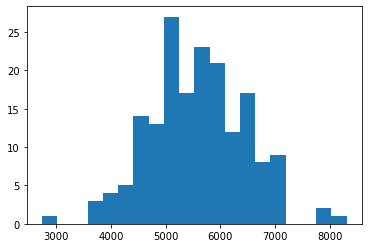

In [308]:
plt.hist(single_blob_areas, bins=20)

In [267]:
all_blobs_enhanced = dict([(k, enhance_blobs(all_blobs[k], median_disk_area)) for k in all_blobs])

In [268]:
all_multi_blobs = [(b, all_blobs_enhanced[b]) for b in all_blobs if len(all_blobs[b]) > 1]

In [269]:
all_multi_blobs

[('d:/Fundus/uploads\\664236dd-9c8c-4554-849f-6efac2131a45.tif_predicted.png_with_blobs.tif',
  [(1,
    (232, 24),
    (328, 106),
    (83, 97),
    8051,
    5523,
    0.6860017389144206,
    6323.240613512857,
    0.8734445417429267,
    0.9846674986628633,
    0.8600524521387386),
   (2,
    (323, 62),
    (323, 67),
    (6, 1),
    6,
    6,
    1.0,
    4.71238898038469,
    0.7853981633974483,
    0.0010697093956141914,
    0.0008401477946843803),
   (3,
    (325, 62),
    (325, 62),
    (1, 1),
    1,
    1,
    1.0,
    0.7853981633974483,
    0.7853981633974483,
    0.00017828489926903192,
    0.00014002463244739674),
   (4,
    (329, 72),
    (329, 75),
    (4, 1),
    4,
    4,
    1.0,
    3.141592653589793,
    0.7853981633974483,
    0.0007131395970761277,
    0.000560098529789587)]),
 ('d:/Fundus/uploads\\bb04943b-2fd9-4e73-ab58-4ffce9baa5e3.tif_predicted.png_with_blobs.tif',
  [(1,
    (243, 36),
    (339, 159),
    (124, 97),
    12028,
    6880,
    0.571998669770535

In [280]:
file_in = 'D:/Fundus/uploads/8e0d4120-c025-41e4-8fe0-dadf2893250d.tif_predicted.png'
file_out = 'D:/Fundus/uploads/8e0d4120-c025-41e4-8fe0-dadf2893250d.tif_predicted_single_blob.tif'

In [295]:
def clear_blobs(keep_blob_index, img, blob_map):
    for a in range(0, img.shape[0]):
        for b in range(0, img.shape[1]):
            if blob_map[a, b] != keep_blob_index and img[a, b] != 0:
                img[a, b] = 0

In [302]:
def extract_most_likely_blob(file_in, file_out, median_disk_area):
    img = cv2.imread(file_in)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_out = cv2.threshold(img_gray, 98, 255, cv2.THRESH_BINARY)
    
    img_blobs, blobs_map = find_blobs(img_out)    
    
    img_enhanced_blobs = enhance_blobs(img_blobs, median_disk_area)
    
    if len(img_enhanced_blobs) > 1:
        img_enhanced_blobs.sort(key = lambda a: a[10], reverse = True)
        best_blob = img_enhanced_blobs[0]
        best_blob_index = best_blob[0]
        clear_blobs(best_blob_index, img_out, blobs_map)
    
    cv2.imwrite(file_out, img_out)
    
    if len(img_enhanced_blobs) > 0:
        return img_enhanced_blobs[0]
    else:
        return None

In [298]:
file_in = 'D:/Fundus/uploads/53915d5f-ddc1-407e-a844-f5e42599828b.tif_predicted.png'
file_out = 'D:/Fundus/uploads/53915d5f-ddc1-407e-a844-f5e42599828b.tif_predicted_single_blob.tif'

In [303]:
file_in = 'D:/Fundus/uploads/f43a0fb8-4c93-4c1f-890c-f95e226c4d66.tif_predicted.png'
file_out = 'D:/Fundus/uploads/f43a0fb8-4c93-4c1f-890c-f95e226c4d66.tif_predicted_single_blob.tif'

In [304]:
extract_most_likely_blob(file_in, file_out, 5600)

(42,
 (247, 114),
 (344, 181),
 (68, 98),
 6664,
 5190,
 0.7788115246098439,
 5233.8933608805955,
 0.9916136310287357,
 0.9267857142857143,
 0.9190133473284176)